In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 7.5MB/s 
     |████████████████████████████████| 9.5MB 37.2MB/s 
     |████████████████████████████████| 2.1MB 29.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


## Importando as bibliotecas

In [ ]:
#Importando as bibliotecas
from pmdarima import auto_arima, AutoARIMA

import pandas as pd
import seaborn as sns
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import OCSBTest, ADFTest, ndiffs
from statsmodels.tsa.api import ExponentialSmoothing

## Coleta de dados

### Coronavírus

In [ ]:
dados_covid = pd.read_csv("/content/drive/MyDrive/Bootcamp Alura/Módulo 04/Arquivos/dados/Covid.csv", encoding="utf-8", sep=";")

In [ ]:
#Exibindo uma amostra dos dados
dados_covid.sample(2)

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
180870,Nordeste,MA,Milagres do Maranhão,21,210667.0,21006.0,CHAPADINHA,2020-03-29,14,8464.0,0,0,0,0,NaN,NaN,0.0
716569,Sudeste,MG,Brasília de Minas,31,310860.0,31049.0,BRASILIA DE MINAS/SAO FRANCISCO,2020-11-04,45,32347.0,200,0,5,0,NaN,NaN,0.0


In [ ]:
#Obtendo mais informações sobre o dataset
dados_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692189 entries, 0 to 1692188
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   regiao                  object 
 1   estado                  object 
 2   municipio               object 
 3   coduf                   int64  
 4   codmun                  float64
 5   codRegiaoSaude          float64
 6   nomeRegiaoSaude         object 
 7   data                    object 
 8   semanaEpi               int64  
 9   populacaoTCU2019        float64
 10  casosAcumulado          int64  
 11  casosNovos              int64  
 12  obitosAcumulado         int64  
 13  obitosNovos             int64  
 14  Recuperadosnovos        float64
 15  emAcompanhamentoNovos   float64
 16  interior/metropolitana  float64
dtypes: float64(6), int64(6), object(5)
memory usage: 219.5+ MB


In [ ]:
#Selecionando os dados correspondentes apenas aos estados
dados_covid = dados_covid.loc[dados_covid["municipio"].isna()]
dados_covid.dropna(subset=["estado"], inplace=True);

In [ ]:
#Selecionando as colunas de interesse
colunas = ["regiao", "estado", "data", "casosAcumulado", "casosNovos", "obitosAcumulado", "obitosNovos"]
dados_covid = dados_covid[colunas] 

In [ ]:
#Verificando a existência de dados faltantes
dados_covid.isna().sum()

regiao             0
estado             0
data               0
casosAcumulado     0
casosNovos         0
obitosAcumulado    0
obitosNovos        0
dtype: int64

In [ ]:
#Transformando a string em data
dados_covid["data"] = dados_covid["data"].astype("datetime64")

In [ ]:
#Exibindo a quantidade de registros e variáveis que há no dataset
print(f"O dataset de dados da COVID-19 possui {dados_covid.shape[0]} registros e {dados_covid.shape[1]} variáveis.")

O dataset de dados da COVID-19 possui 15285 registros e 7 variáveis.


## Entendendo os dados

In [ ]:
plt.style.use("ggplot")
sns.set_palette("deep")

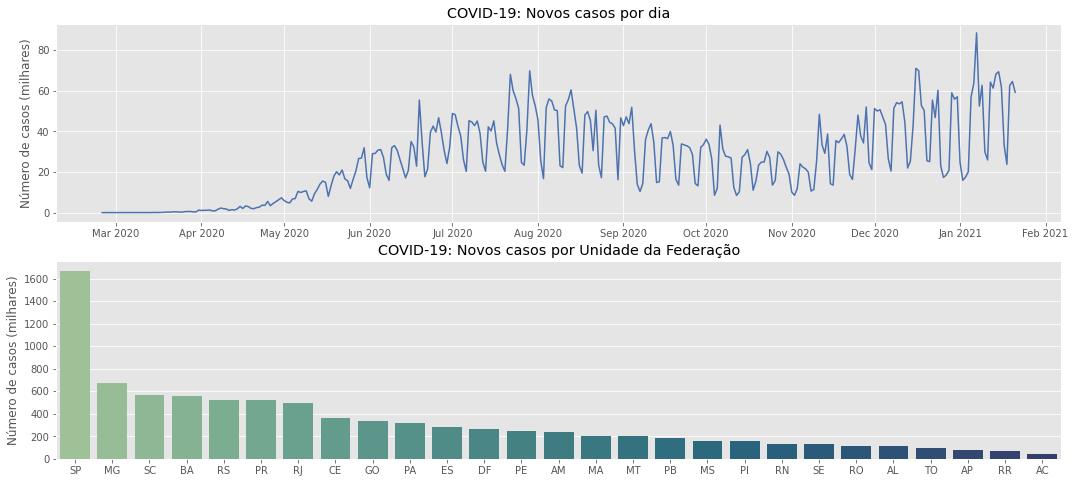

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,8), sharex=False)

x1 = dados_covid.groupby("data").sum()["casosNovos"].index
sns.lineplot(ax=ax1, x=x1, y=dados_covid.groupby("data").sum()["casosNovos"]/1000)
ax1.set_title("COVID-19: Novos casos por dia")
ax1.set_ylabel("Número de casos (milhares)")
ax1.set_xlabel("")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

x2 = dados_covid.groupby("estado").sum()["casosNovos"].reset_index()
x2_ordenado = x2.sort_values("casosNovos", ascending=False)["estado"]
sns.barplot(ax=ax2, x=x2["estado"], y=x2["casosNovos"]/1000, order=x2_ordenado, palette="crest")
ax2.set_title("COVID-19: Novos casos por Unidade da Federação")
ax2.set_ylabel("Número de casos (milhares)")
ax2.set_xlabel("")

plt.show()

## Previsão de séries temporais

### Regressão Linear Simples

In [ ]:
#Selecionando os dados a partir do 100º caso
casos = dados_covid.groupby("data").sum()["casosNovos"].reset_index()
casos = casos.query("casosNovos > 100")
casos.reset_index(drop=True, inplace=True)
casos["Ano"] = casos["data"].dt.year
casos.set_index("data", inplace=True)

#Separando os dados de treino e de teste
casos_treino = casos.loc[casos["Ano"] == 2020]["casosNovos"]
casos_teste = casos.loc[casos["Ano"] == 2021]["casosNovos"]

#Instanciando o modelo
model = LinearRegression()

#Ajustando o modelo
X = np.expand_dims(np.linspace(0,len(casos_treino), len(casos_treino)), axis=1)
y = np.expand_dims(casos_treino, axis=1)
model.fit(X,y)

#Prevendo os próximos 21 dias
casos_previsao = model.predict(np.expand_dims(np.linspace(0, len(casos_treino)+21, len(casos)), axis=1))

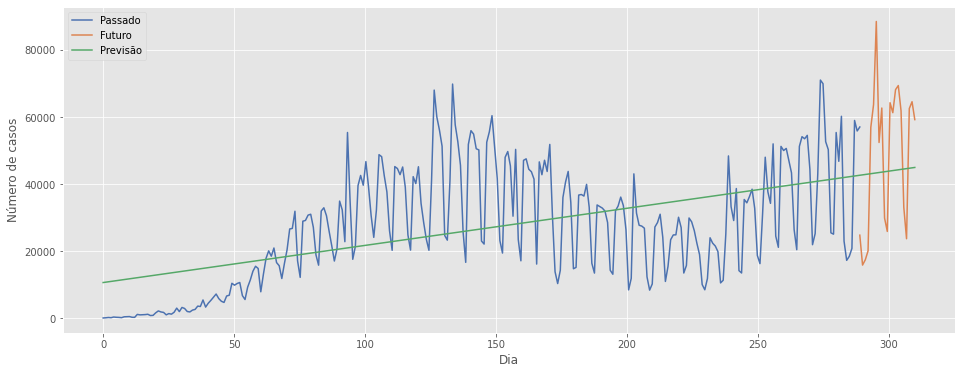

In [ ]:
#Plotando o resultado
plt.figure(figsize=(16,6))
plt.plot(np.linspace(0,len(casos_treino), len(casos_treino)), casos_treino, label='Passado')
plt.plot(np.linspace(len(casos_treino), len(casos_treino)+21, 21), casos_teste, label = 'Futuro')
plt.plot(np.linspace(0, len(casos_previsao), len(casos_previsao)), casos_previsao, label = 'Previsão')
plt.xlabel("Dia")
plt.ylabel("Número de casos")
plt.legend()

plt.show()

### Regressão de uma Função Polinomial

In [ ]:
#Instanciando Modelo  
poly = PolynomialFeatures(degree = 4) 
X_poly = poly.fit_transform(X)

#Treinando o modelo 
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y)

#Prevendo os próximos 21 dias
casos_previsao_polinomial = lin2.predict(poly.fit_transform(np.expand_dims(np.linspace(0, len(casos_treino)+21, len(casos)), axis=1)))

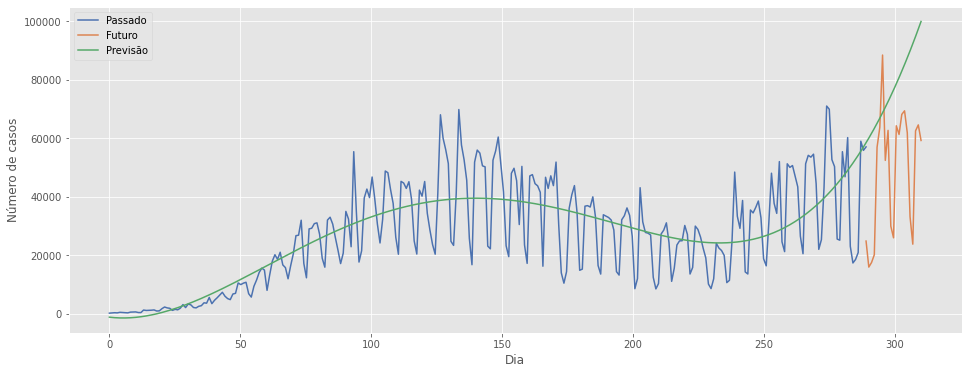

In [ ]:
#Plotando o resultado
plt.figure(figsize=(16,6))
plt.plot(np.linspace(0,len(casos_treino), len(casos_treino)), casos_treino, label='Passado')
plt.plot(np.linspace(len(casos_treino), len(casos_treino)+21, 21), casos_teste, label = 'Futuro')
plt.plot(np.linspace(0, len(casos_previsao), len(casos_previsao)), casos_previsao_polinomial, label = 'Previsão')
plt.xlabel("Dia")
plt.ylabel("Número de casos")
plt.legend();

### Média Móvel

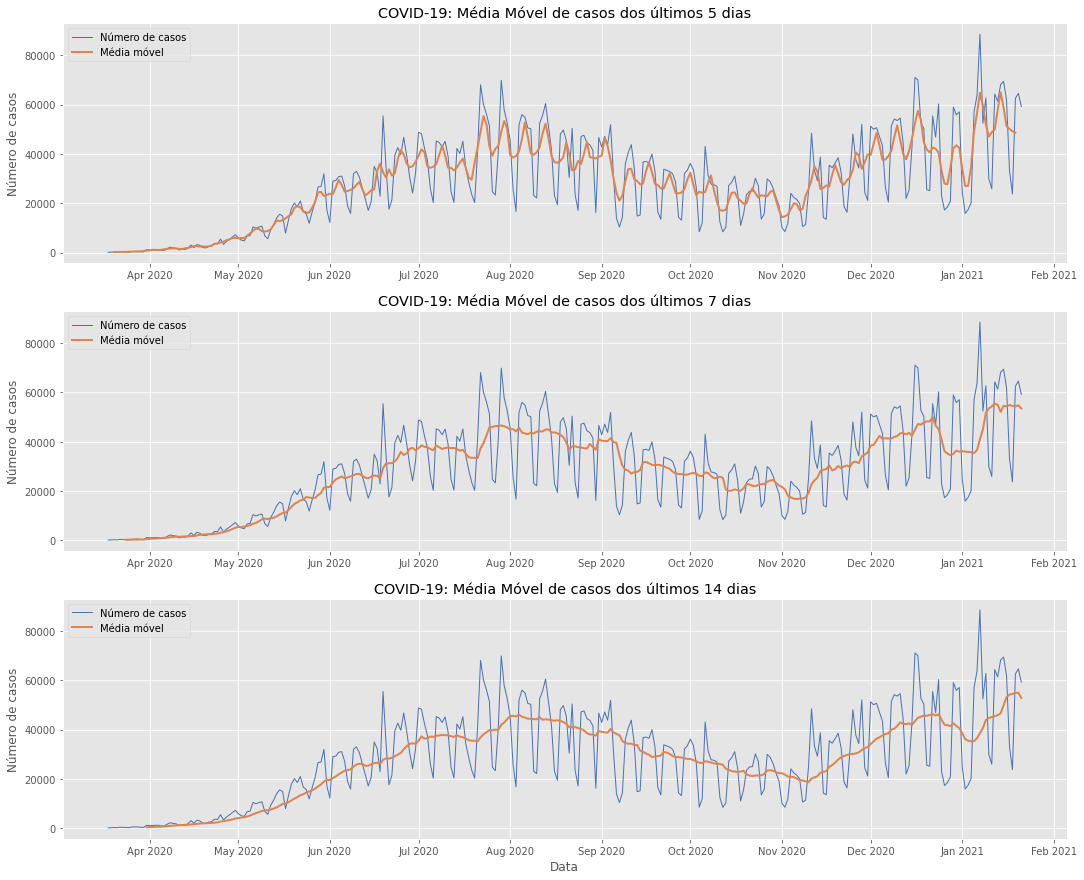

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,15), sharex=False)

novos_casos = dados_covid.groupby("data").sum()["casosNovos"].reset_index()
novos_casos = novos_casos.query("casosNovos > 100")
novos_casos.reset_index(drop=True, inplace=True)

novos_casos["Media_Movel_5"] = novos_casos["casosNovos"].rolling(5, center=True).mean()
sns.lineplot(ax=ax1, x="data", y="casosNovos", data=novos_casos, linewidth=1)
sns.lineplot(ax=ax1, x="data", y="Media_Movel_5", data=novos_casos, linewidth=2)
ax1.set_title("COVID-19: Média Móvel de casos dos últimos 5 dias")
ax1.set_ylabel("Número de casos")
ax1.set_xlabel("")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.legend(labels=["Número de casos", "Média móvel"])

novos_casos["Media_Movel_7"] = novos_casos["casosNovos"].rolling(7).mean()
sns.lineplot(ax=ax2, x="data", y="casosNovos", data=novos_casos, linewidth=1)
sns.lineplot(ax=ax2, x="data", y="Media_Movel_7", data=novos_casos, linewidth=2)
ax2.set_title("COVID-19: Média Móvel de casos dos últimos 7 dias")
ax2.set_ylabel("Número de casos")
ax2.set_xlabel("")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.legend(labels=["Número de casos", "Média móvel"])

novos_casos["Media_Movel_14"] = novos_casos["casosNovos"].rolling(14).mean()
sns.lineplot(ax=ax3, x="data", y="casosNovos", data=novos_casos, linewidth=1)
sns.lineplot(ax=ax3,  x="data", y="Media_Movel_14", data=novos_casos, linewidth=2)
ax3.set_title("COVID-19: Média Móvel de casos dos últimos 14 dias")
ax3.set_ylabel("Número de casos")
ax3.set_xlabel("Data")
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.legend(labels=["Número de casos", "Média móvel"])

plt.show()

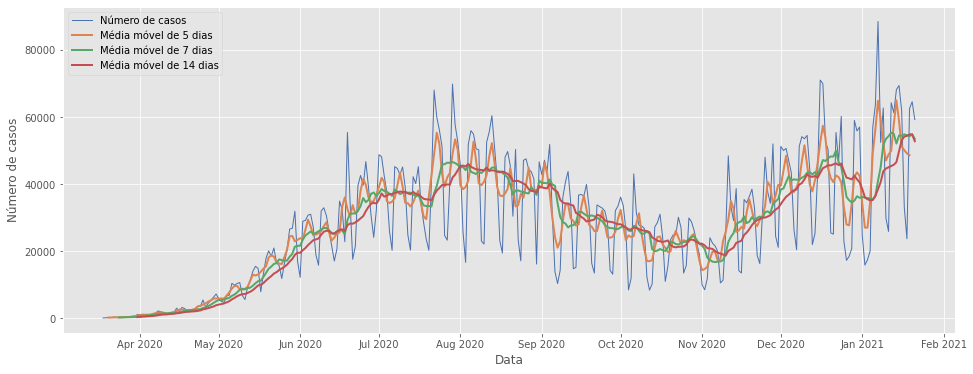

In [ ]:
plt.figure(figsize=(16,6))
ax = plt.gca()
sns.lineplot(x="data", y="casosNovos", data=novos_casos, linewidth=1)
sns.lineplot(x="data", y="Media_Movel_5", data=novos_casos, linewidth=2)
sns.lineplot(x="data", y="Media_Movel_7", data=novos_casos, linewidth=2)
sns.lineplot(x="data", y="Media_Movel_14", data=novos_casos, linewidth=2)
plt.legend(labels=["Número de casos", "Média móvel de 5 dias", "Média móvel de 7 dias", "Média móvel de 14 dias"])
plt.ylabel("Número de casos")
plt.xlabel("Data")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.show()

### Teste Aumentado de Dick-Fuller 

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are a number of unit root tests and the Augmented Dickey-Fuller may be one of the more widely used. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
X = casos["casosNovos"]
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("usedlag: %f" % result[2])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.569311
p-value: 0.498989
usedlag: 15.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary

### Decomposição das séries temporais

- Modelo aditivo

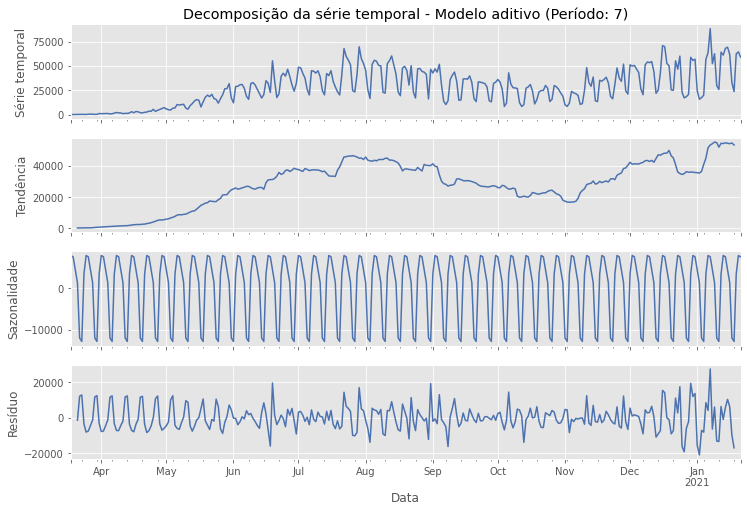

In [ ]:
#Período: 7
decomposicao_casos = seasonal_decompose(casos["casosNovos"], model="aditive", period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,8), sharex=True)
decomposicao_casos.observed.plot(ax=ax1)
decomposicao_casos.trend.plot(ax=ax2)
decomposicao_casos.seasonal.plot(ax=ax3)
decomposicao_casos.resid.plot(ax=ax4)
ax1.set_title("Decomposição da série temporal - Modelo aditivo (Período: 7)")
ax1.set_ylabel("Série temporal")
ax2.set_ylabel("Tendência")
ax3.set_ylabel("Sazonalidade")
ax4.set_ylabel("Resíduo")
ax4.set_xlabel("Data")

plt.show()

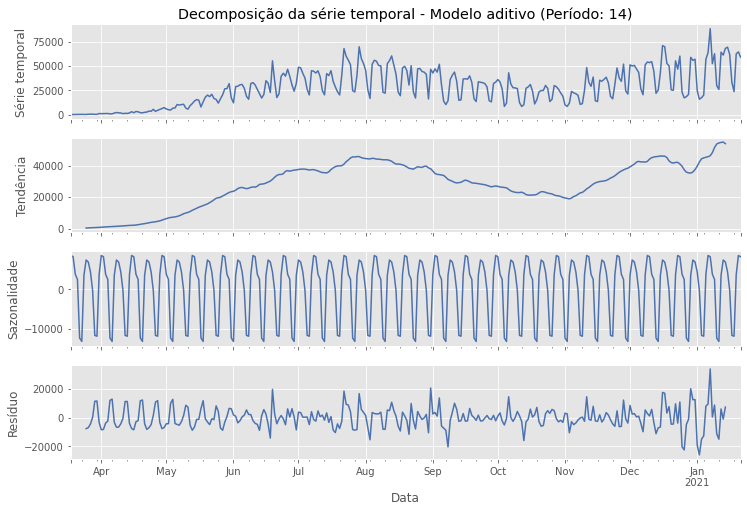

In [ ]:
#Período: 7
decomposicao_casos = seasonal_decompose(casos["casosNovos"], model="aditive", period=14)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,8), sharex=True)
decomposicao_casos.observed.plot(ax=ax1)
decomposicao_casos.trend.plot(ax=ax2)
decomposicao_casos.seasonal.plot(ax=ax3)
decomposicao_casos.resid.plot(ax=ax4)
ax1.set_title("Decomposição da série temporal - Modelo aditivo (Período: 14)")
ax1.set_ylabel("Série temporal")
ax2.set_ylabel("Tendência")
ax3.set_ylabel("Sazonalidade")
ax4.set_ylabel("Resíduo")
ax4.set_xlabel("Data")

plt.show()

- Modelo multiplicativo

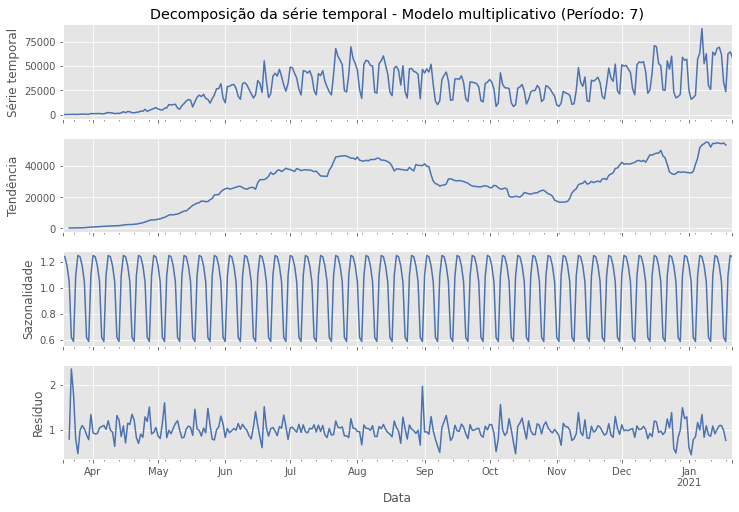

In [ ]:
#Período: 7
decomposicao_casos = seasonal_decompose(casos["casosNovos"], model="multiplicative", period=7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,8), sharex=True)
decomposicao_casos.observed.plot(ax=ax1)
decomposicao_casos.trend.plot(ax=ax2)
decomposicao_casos.seasonal.plot(ax=ax3)
decomposicao_casos.resid.plot(ax=ax4)
ax1.set_title("Decomposição da série temporal - Modelo multiplicativo (Período: 7)")
ax1.set_ylabel("Série temporal")
ax2.set_ylabel("Tendência")
ax3.set_ylabel("Sazonalidade")
ax4.set_ylabel("Resíduo")
ax4.set_xlabel("Data")

plt.show()

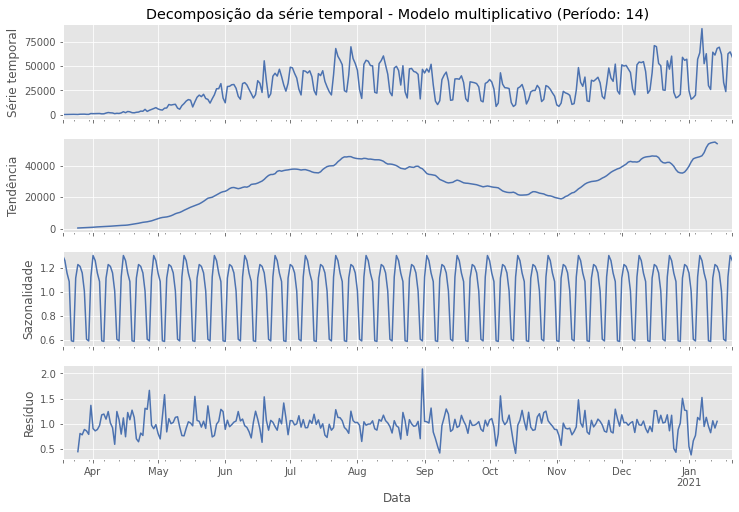

In [ ]:
#Período: 14
decomposicao_casos = seasonal_decompose(casos["casosNovos"], model="multiplicative", period=14)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,8), sharex=True)
decomposicao_casos.observed.plot(ax=ax1)
decomposicao_casos.trend.plot(ax=ax2)
decomposicao_casos.seasonal.plot(ax=ax3)
decomposicao_casos.resid.plot(ax=ax4)
ax1.set_title("Decomposição da série temporal - Modelo multiplicativo (Período: 14)")
ax1.set_ylabel("Série temporal")
ax2.set_ylabel("Tendência")
ax3.set_ylabel("Sazonalidade")
ax4.set_ylabel("Resíduo")
ax4.set_xlabel("Data")

plt.show()

### Autocorrelação

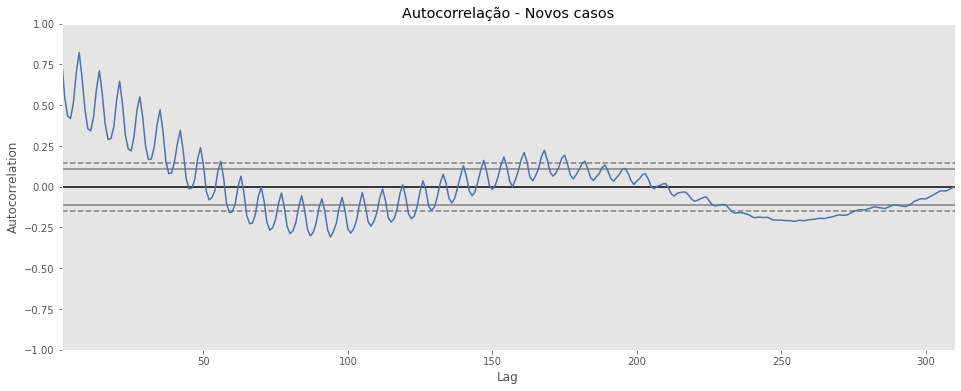

In [ ]:
plt.figure(figsize=(16,6))
x1 = pd.plotting.autocorrelation_plot(casos["casosNovos"]) 
x1.plot
plt.title("Autocorrelação - Novos casos")
 
plt.show()

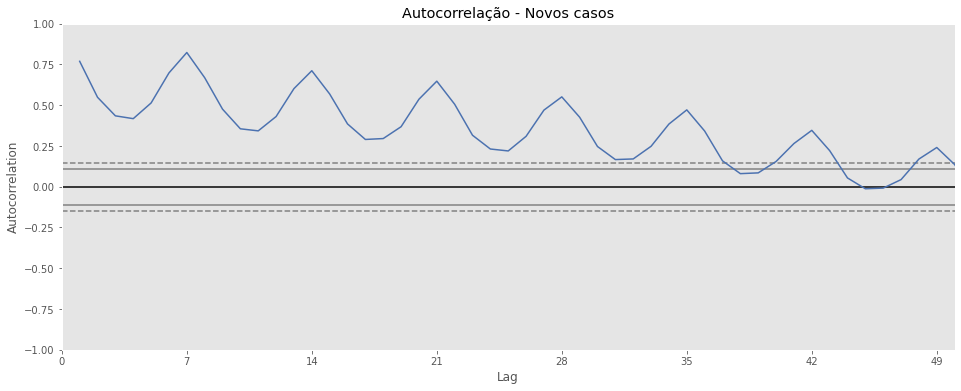

In [ ]:
plt.figure(figsize=(16,6))
x2 = pd.plotting.autocorrelation_plot(casos["casosNovos"]) 
x2.plot
plt.title("Autocorrelação - Novos casos")
plt.xlim(0,50)
plt.xticks(np.arange(0, 50, 7))
 
plt.show()

>O mais correto é fazer a autocorrelação da série diferenciada.

In [ ]:
casos["Aumento"] = casos["casosNovos"].diff()
casos["Aceleração"] = casos["Aumento"].diff()

- Método 1 - Teste KPSS:

In [ ]:
ndiffs(casos["casosNovos"], alpha=.05, test="kpss", max_d=2)

1

In [ ]:
adf_test = ADFTest(alpha=0.5)
adf_test.should_diff(casos["Aumento"].dropna())

(0.01, False)

- Método 2 - Teste Aumentado de Dick-Fuller:

In [ ]:
X = casos["Aumento"].dropna()
result = adfuller(X)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print("usedlag: %f" % result[2])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.715562
p-value: 0.000001
usedlag: 16.000000
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary

**Autocorrelação da série diferenciada**

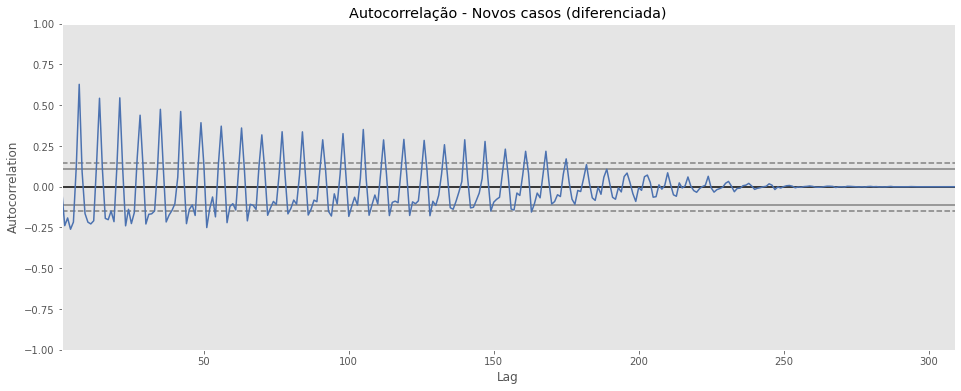

In [ ]:
plt.figure(figsize=(16,6))
x1 = pd.plotting.autocorrelation_plot(casos["Aumento"].dropna())
x1.plot
plt.title("Autocorrelação - Novos casos (diferenciada)")
 
plt.show()

### Função de autocorrelação (ACF) e função de autocorrelação parcial (PACF)

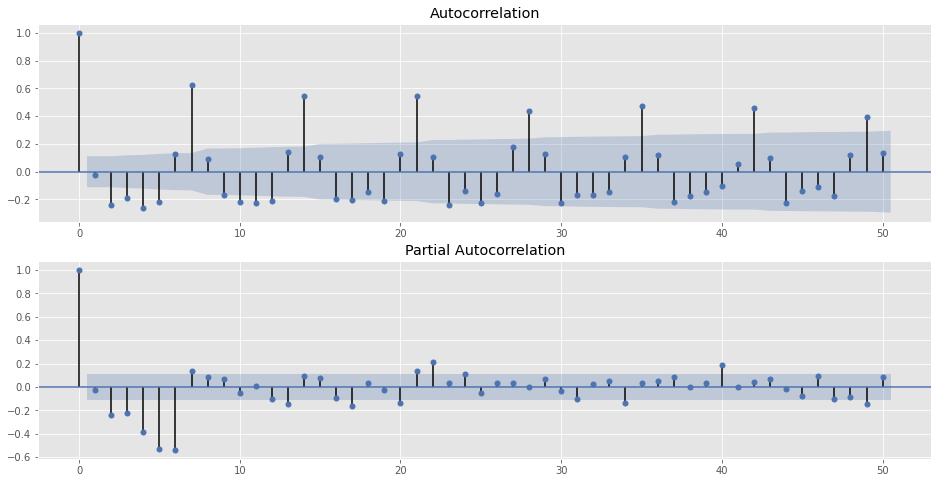

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))

plot_acf(casos["Aumento"].dropna(), lags= 50, ax=ax1)
plot_pacf(casos["Aumento"].dropna(),lags= 50, ax=ax2)

plt.show()

### Previsão Algoritmo Holt-Winters

https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

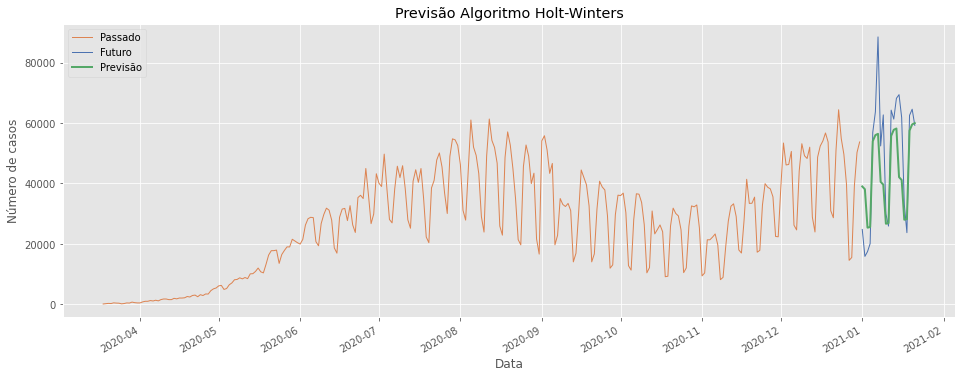

In [ ]:
plt.figure(figsize=(16,6))
fit = ExponentialSmoothing(casos_treino, seasonal_periods=7, trend='add', seasonal='add').fit(use_boxcox=True)
plt.plot(casos_teste, label="Futuro", lw=1)
fit.fittedvalues.plot(label="Passado", lw=1)
fit.forecast(21).plot(legend=True, label="Previsão", lw=2)
handles, labels = plt.gca().get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = [labels[1], labels[0], labels[2]]
plt.legend(handles, labels)
plt.title("Previsão Algoritmo Holt-Winters")
plt.ylabel("Número de casos")
plt.xlabel("Data")

plt.show()

### Previsão Modelo ARIMA

In [ ]:
#Dados de treino e teste foram separados anteriormente
#casos_treino = casos.loc[casos["Ano"] == 2020]["casosNovos"]
#casos_teste = casos.loc[casos["Ano"] == 2021]["casosNovos"]

In [ ]:
p = d = q = range(0,5)
combinacoes_pdq = list(itertools.product(p,d,q))

In [ ]:
%%time

menor_aic = -1
melhor_pdq = (0, 0, 0)

for pdq in combinacoes_pdq:
    try:
        model_arima = ARIMA(casos_treino, order = pdq)
        model_arima_fit = model_arima.fit()
        
        print(pdq, model_arima_fit.aic)
        
        if menor_aic == -1:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
        elif model_arima_fit.aic < menor_aic:
            menor_aic = model_arima_fit.aic
            melhor_pdq = pdq
    except:
        continue

(0, 0, 0) 6469.01602078535
(0, 0, 1) 6273.412930081087
(0, 0, 2) 6229.5112447178835
(0, 0, 3) 6208.744478390467
(0, 0, 4) 6180.695033980524
(0, 1, 0) 6205.2710057191025
(0, 1, 1) 6207.158651805128
(0, 1, 2) 6114.613297986993
(0, 1, 3) 6115.574995787122
(0, 1, 4) 6106.005120306653
(0, 2, 0) 6387.246493744264
(0, 2, 1) 6192.39887744662
(0, 2, 2) 6194.34117382489
(0, 2, 3) 6097.539899156636
(0, 2, 4) 6097.709751446023
(1, 0, 0) 6198.263088844153
(1, 0, 1) 6194.264699590341
(1, 0, 2) 6142.12881005188
(1, 0, 3) 6142.277034272434
(1, 0, 4) 6132.883053645536
(1, 1, 0) 6207.225785537404
(1, 1, 1) 6141.4391062770665
(1, 1, 2) 6115.955360023181
(1, 1, 3) 6099.947718735888
(1, 1, 4) 6093.2647108942865
(1, 2, 0) 6349.385147308344
(1, 2, 3) 6095.642751074223
(2, 0, 0) 6196.772273538477
(2, 0, 1) 6168.891254607453
(2, 0, 2) 6143.574826929295
(2, 0, 3) 6121.779453827095
(2, 0, 4) 6118.111130731311
(2, 1, 0) 6183.202844365911
(2, 1, 1) 6100.117586974236
(2, 1, 2) 6059.300013501192
(2, 1, 4) 6008.98414

In [ ]:
print('menor_aic = {}, melhor_pdq = {}'.format(menor_aic, melhor_pdq))

menor_aic = 5960.140420371171, melhor_pdq = (4, 1, 4)


In [ ]:
#Instanciando o modelo ARIMA
#Apenas o dados de treino
modelo_arima = ARIMA(casos_treino.values, order=[4,1,4]) 

#Ajustando/treinando o modelo
modelo_arima_treinado = modelo_arima.fit()

#Realizando a previsão
previsao_arima = modelo_arima_treinado.forecast(21)[0] 
#O primeiro elemento da tupla é a previsão

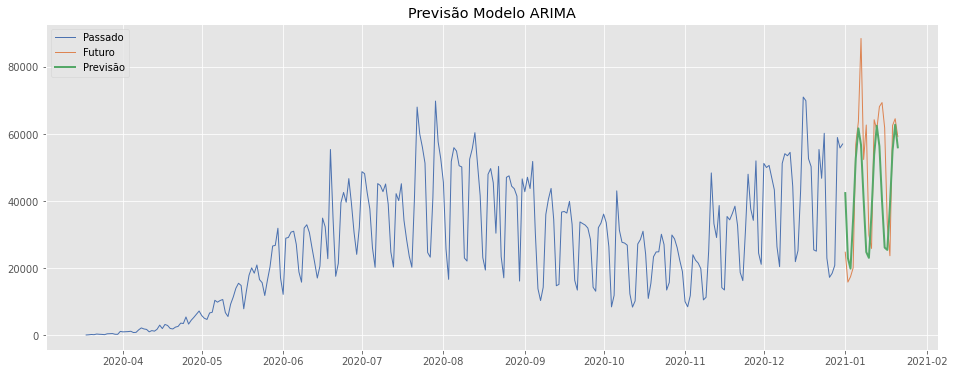

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(casos_treino, label="Passado", lw=1)
plt.plot(casos_teste, label="Futuro", lw=1)
plt.plot(casos_teste.index, previsao_arima, label = "Previsão", lw=2)
plt.title("Previsão Modelo ARIMA")
plt.legend()

plt.show()

### Previsão Modelo SARIMA

In [ ]:
#Dados de treino e teste foram separados anteriormente
#casos_treino = casos.loc[casos["Ano"] == 2020]["casosNovos"]
#casos_teste = casos.loc[casos["Ano"] == 2021]["casosNovos"]

In [ ]:
modelo_sarima = auto_arima(casos_treino,
                     start_p=0, start_q=0, max_p=10, max_q=10,
                     d=1, m=7, seasonal = True,
                     D=1, start_Q=1, start_P=1, max_P=4, max_Q=4,
                     trace=True,
                     error_action='ignore', suppress_warnings=True,
                     stepwise=False)

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=5977.019, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=5878.622, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=5883.219, Time=0.34 sec
 ARIMA(0,1,0)(0,1,3)[7]             : AIC=5895.785, Time=0.63 sec
 ARIMA(0,1,0)(0,1,4)[7]             : AIC=5896.195, Time=1.26 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=5919.134, Time=0.07 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=5878.112, Time=0.19 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=5874.039, Time=0.85 sec
 ARIMA(0,1,0)(1,1,3)[7]             : AIC=5884.592, Time=1.03 sec
 ARIMA(0,1,0)(1,1,4)[7]             : AIC=5884.174, Time=1.93 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=5882.213, Time=0.19 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=5875.233, Time=0.56 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=5872.691, Time=0.87 sec
 ARIMA(0,1,0)(2,1,3)[7]             : AIC=5880.066, Time=2.10 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=5884.010, Time=0.48 sec
 ARIMA(0,1

In [ ]:
#Treino
modelo_sarima.fit(casos_treino)

#Predição
fitted = modelo_sarima.predict_in_sample(start=1, end=len(casos_treino))
previsao_sarima = modelo_sarima.predict(n_periods=len(casos_teste))

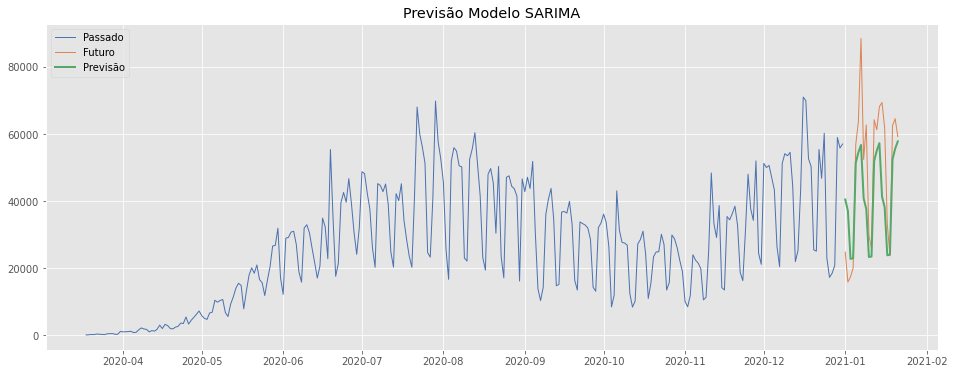

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(casos_treino, label="Passado", lw=1)
plt.plot(casos_teste, label="Futuro", lw=1)
plt.plot(casos_teste.index, previsao_sarima, label = "Previsão", lw=2)
plt.title("Previsão Modelo SARIMA")
plt.legend()

plt.show()

**Comparação ARIMA e SARIMA**

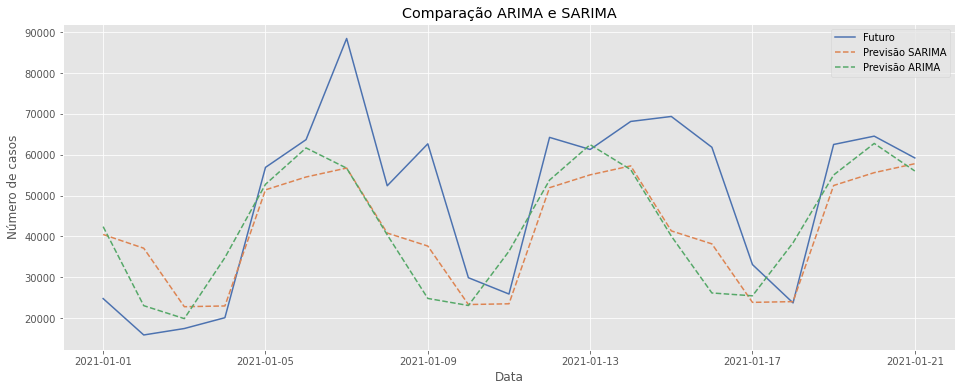

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(casos_teste, label="Futuro")
plt.plot(casos_teste.index, previsao_sarima, label = "Previsão SARIMA", ls="--")
plt.plot(casos_teste.index, previsao_arima, label = "Previsão ARIMA", ls="--")
plt.title("Comparação ARIMA e SARIMA")
plt.ylabel("Número de casos")
plt.xlabel("Data")
plt.legend()

plt.show()

In [ ]:
resultado_sarima = mean_squared_error(casos_teste, previsao_sarima)
resultado_arima = mean_squared_error(casos_teste, previsao_arima)
print(f"SARIMA = {resultado_sarima}")
print(f"ARIMA = {resultado_arima}")

SARIMA = 218220016.98759902
ARIMA = 288980525.1696553
